# 01_summary_statistics.ipynb

In [26]:
import contextily as cx
import figure_utilities
import figure_and_table_constants
import constants
from stats_utilities import produce_summary_statistics
from panel_utilities import convert_weekly_panel_to_biweekly_panel
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import os
import pandas as pd

# Store paths.
INPUT_DATA_UNRESTRICTED = "../../data/03_cleaned/unrestricted_monthly.parquet"
INPUT_DATA_RESTRICTED = "../../data/03_cleaned/crime_analysis_monthly.parquet"
INPUT_DATA_TRACTS = "../../data/02_intermediate/tracts.csv"
INPUT_DATA_BOSTON_TRACTS_SHAPEFILE = "../../data/01_raw/Census_2010_Tracts"

OUTPUT_TABLES = "../../output/summary_statistics/tables"
OUTPUT_FIGURES = "../../output/summary_statistics/figures"

# Read unrestricted dataset into memory.
unrestricted_df = pd.read_parquet(INPUT_DATA_UNRESTRICTED)

# Drop malformed addresses.
unrestricted_df = unrestricted_df.loc[~unrestricted_df['property_address_full'].str.contains("span, span span"), :]

# So we can use 'case_number' like a column
unrestricted_df = unrestricted_df.reset_index()

# Restrict to Boston evictions.
boston_mask = ((unrestricted_df['County'] == "Suffolk County") & (~unrestricted_df['City'].isin(["Chelsea", "Revere", "Winthrop"])))
unrestricted_df = unrestricted_df.loc[boston_mask, :]

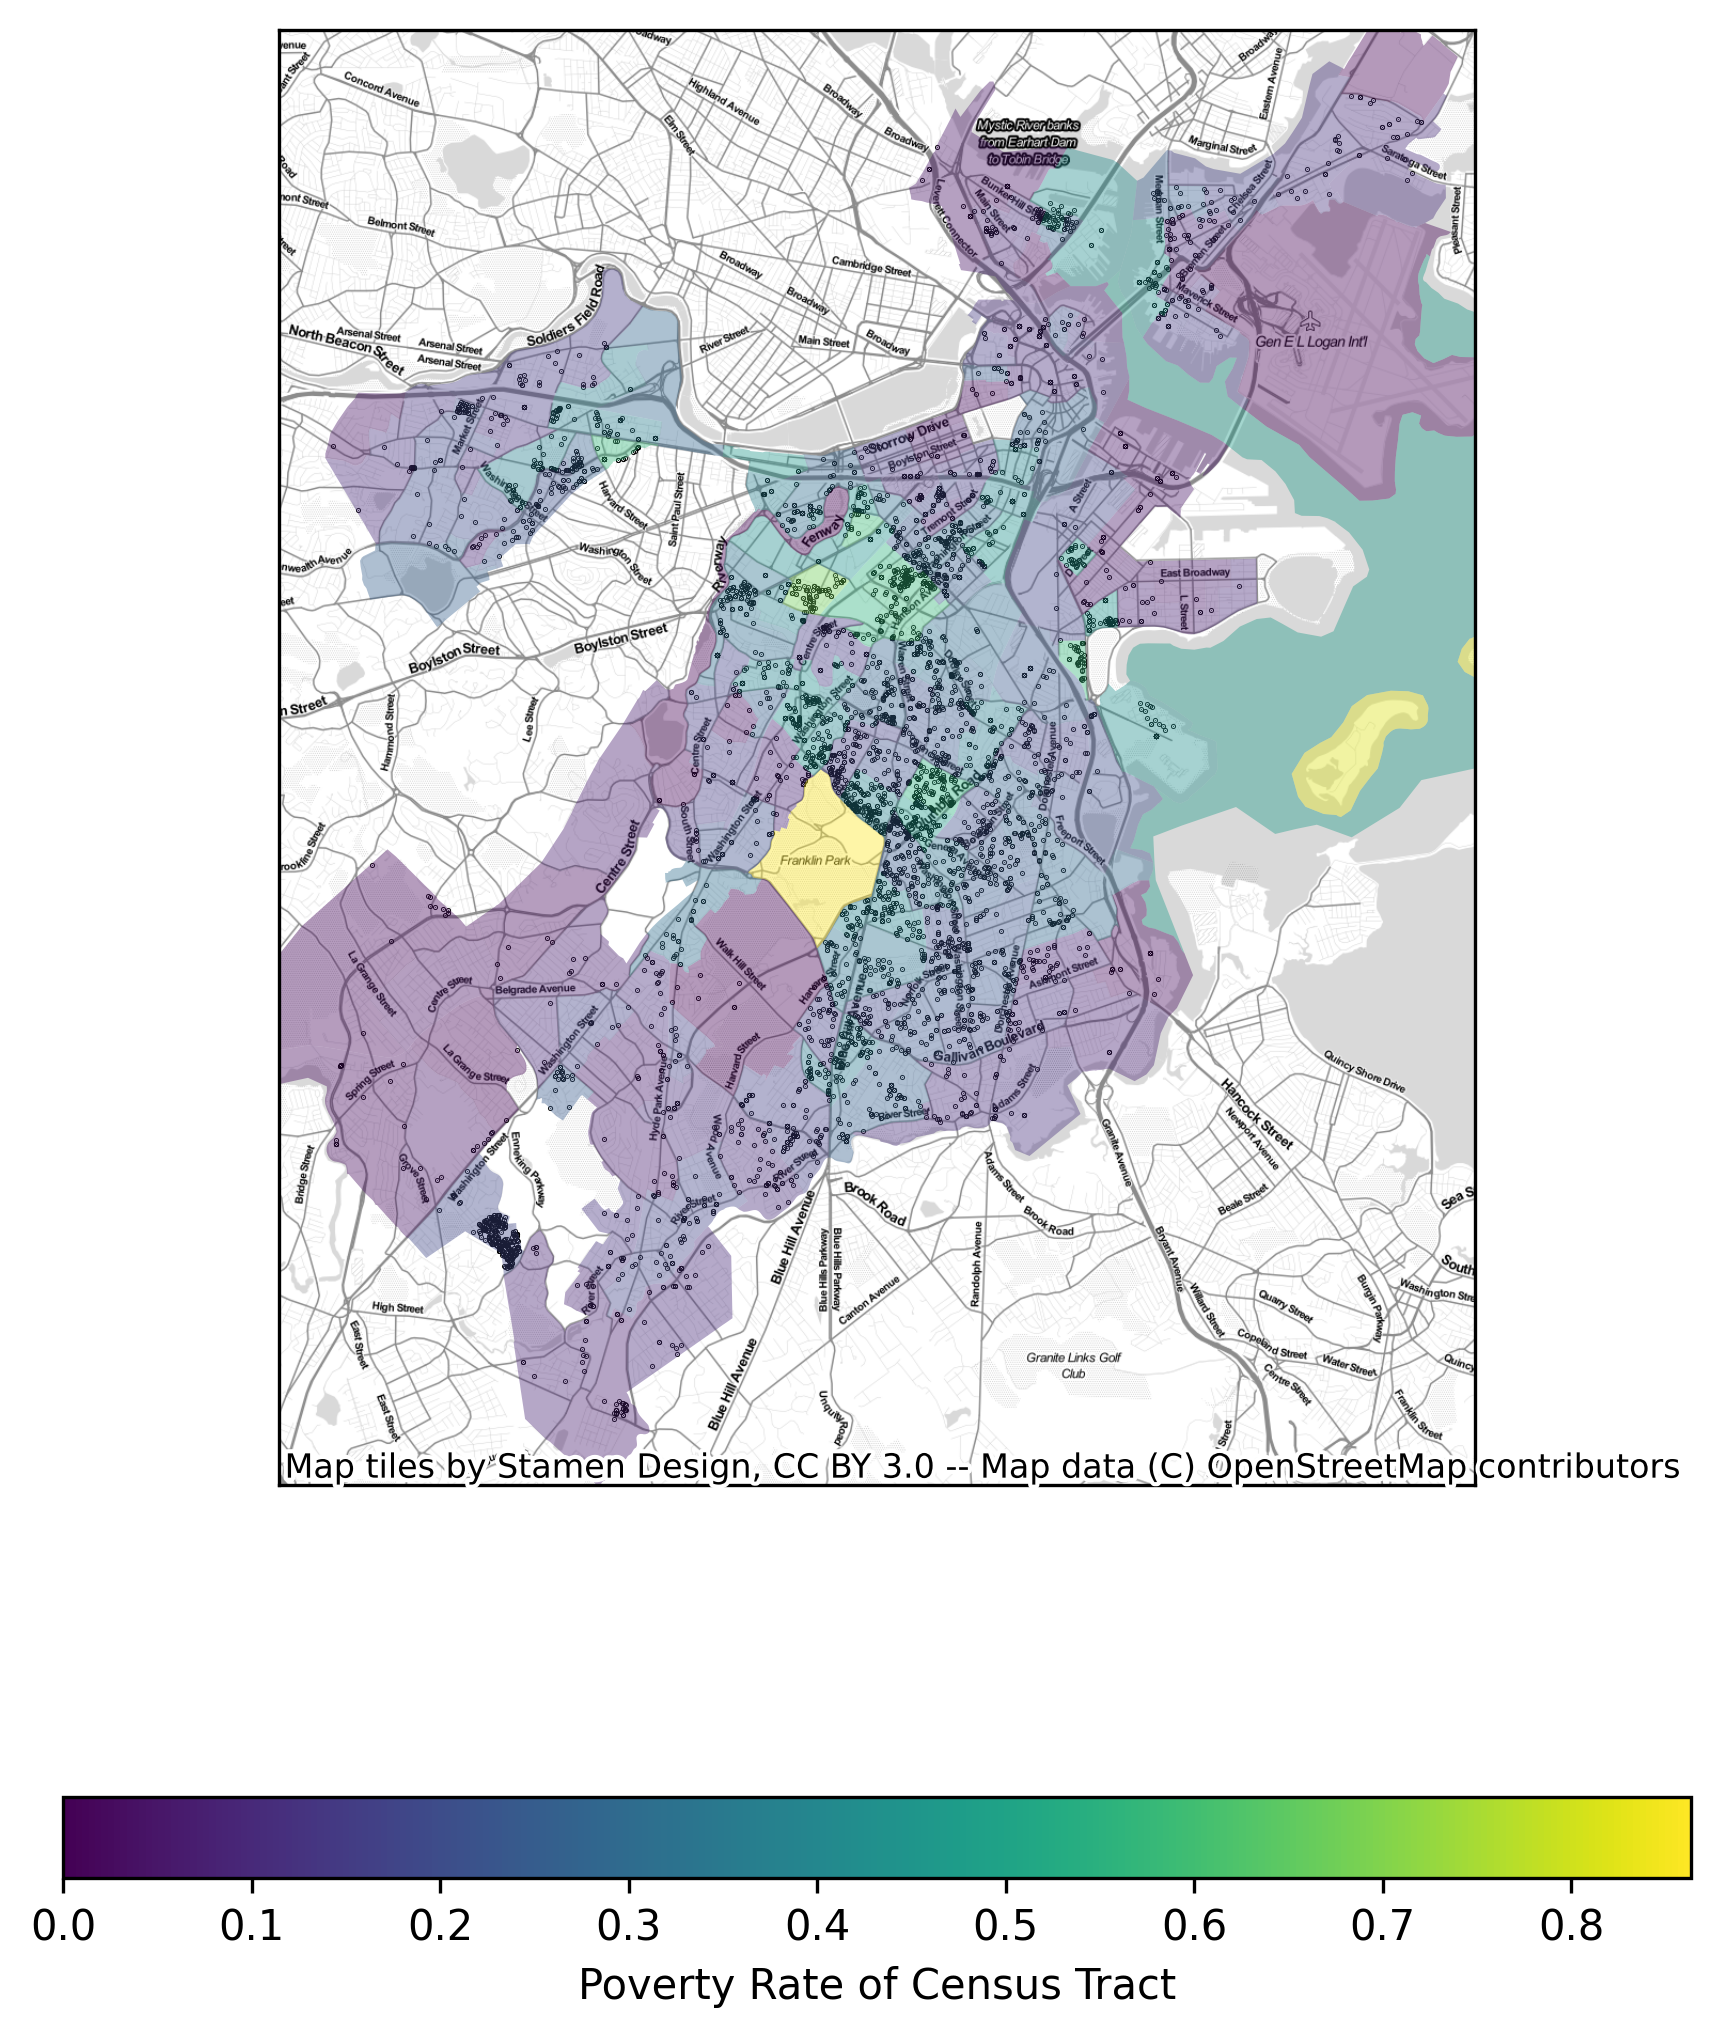

In [27]:
# Plot evictions spatially.
unrestricted_gdf = gpd.GeoDataFrame(unrestricted_df,
                                    geometry=gpd.points_from_xy(unrestricted_df['longitude'],
                                                                unrestricted_df['latitude']))
unrestricted_gdf = unrestricted_gdf.set_crs("EPSG:4326")
unrestricted_gdf = unrestricted_gdf.to_crs("EPSG:3857")
fig, ax = plt.subplots(figsize=(7, 9))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
unrestricted_gdf.plot(ax=ax,
                      color='black',
                      markersize=0.05)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.Stamen.TonerLite)

# Color census tracts by poverty rate.
boston_tracts_gdf = gpd.read_file(INPUT_DATA_BOSTON_TRACTS_SHAPEFILE)[['GEOID10', 'geometry']].set_index('GEOID10')
boston_tracts_gdf.index = boston_tracts_gdf.index.astype(int)
tract_poverty_rates_df = pd.read_csv(INPUT_DATA_TRACTS, usecols=['tract_geoid', 'poor_share2010'], index_col='tract_geoid')

boston_tracts_gdf = pd.concat([boston_tracts_gdf, tract_poverty_rates_df], axis=1).dropna(subset=['geometry', 'poor_share2010'])
boston_tracts_gdf.plot(ax=ax, column=boston_tracts_gdf['poor_share2010'], alpha=0.4, legend=True, legend_kwds={'label': "Poverty Rate of Census Tract",
                                                                                                               'orientation': "horizontal"})


plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "evictions_map.png"))

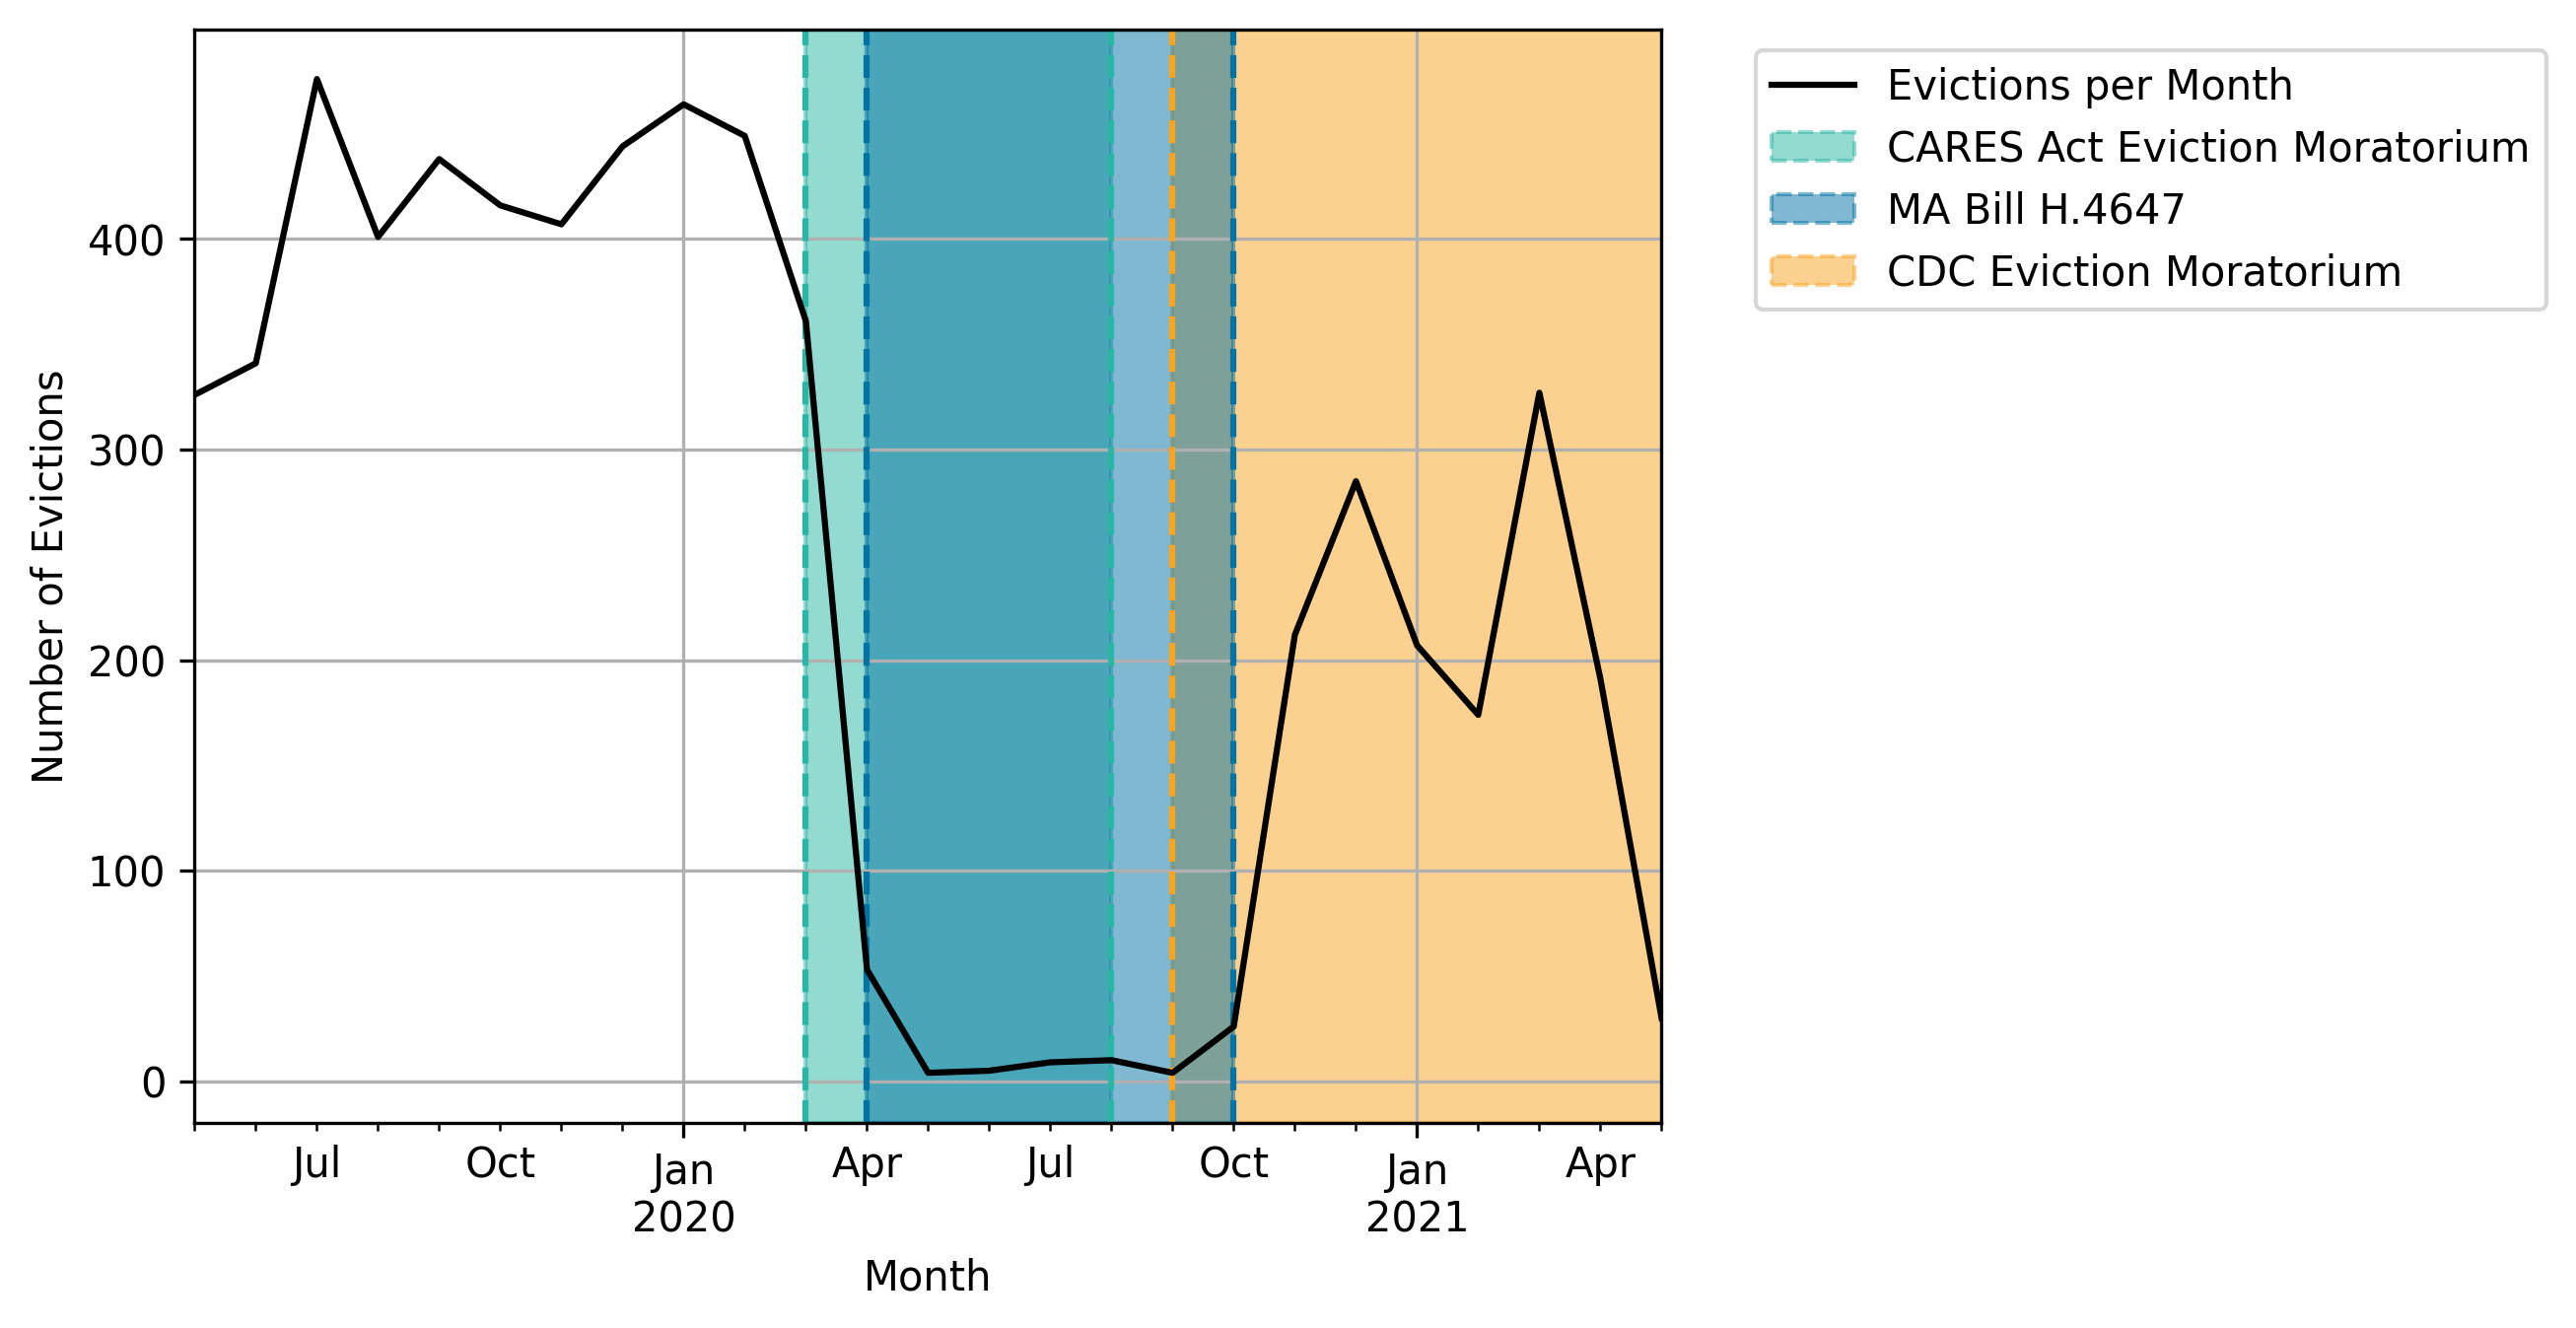

In [28]:
# Plot the number of eviction filings over time.
unrestricted_df.loc[:, 'last_day_of_file_month'] = (pd.to_datetime(unrestricted_df['file_date']) +
                                                    pd.tseries.offsets.MonthEnd(0))
filings_per_month = unrestricted_df.groupby('last_day_of_file_month')['case_number'].count()

# Plot eviction filing counts.
fig, ax = plt.subplots()
filings_per_month.plot(ax=ax, kind='line', color=figure_and_table_constants.Colors.SUMMARY_STATISTICS_COLOR,
                       zorder=100)
ax.set_ylabel("Number of Evictions")
ax.set_xlabel("Month")
ax.grid(True)

# Plot the beginning and end of the CARES act moratorium.
CARES_beginning = pd.Timestamp("2020-03-27")
CARES_end = pd.Timestamp("2020-08-23")
CARES_color = figure_and_table_constants.Colors.P1
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_beginning, text='', color=CARES_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_end, text='', color=CARES_color)
ax.axvspan(CARES_beginning, CARES_end, color=CARES_color, alpha=0.5)

# Plot the beginning and end of the CDC moratorium.
CDC_beginning = pd.Timestamp("2020-09-04")
CDC_end = pd.Timestamp("2021-08-26")
CDC_color = figure_and_table_constants.Colors.P2
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_beginning, text='', color=CDC_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_end, text='', color=CDC_color)
ax.axvspan(CDC_beginning, CDC_end, color=CDC_color, alpha=0.5)

# Plot the beginning and end of the MA state moratorium.
MA_beginning = pd.Timestamp("2020-04-20")
MA_end = pd.Timestamp("2020-10-17")
MA_color = figure_and_table_constants.Colors.P7
figure_utilities.plot_labeled_vline(ax=ax, x=MA_beginning, text='', color=MA_color)
figure_utilities.plot_labeled_vline(ax=ax, x=MA_end, text='', color=MA_color)
ax.axvspan(MA_beginning, MA_end, color=MA_color, alpha=0.5)

# Build legend.
legend_elements = [Line2D([0], [0], color='black', label='Evictions per Month'),
                   Patch(facecolor=CARES_color, edgecolor=CARES_color, label='CARES Act Eviction Moratorium',
                         alpha=0.5, linestyle='--'),
                   Patch(facecolor=MA_color, edgecolor=MA_color, label='MA Bill H.4647', alpha=0.5,
                         linestyle='--'),
                   Patch(facecolor=CDC_color, edgecolor=CDC_color, label='CDC Eviction Moratorium', alpha=0.5,
                         linestyle='--')]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "filings_over_time.png"))

In [29]:
# Produce summary statistics for unrestricted sample.
treatment_date_variable = 'latest_docket_date'
outcomes_of_interest = ['group_0_crimes_500m']
unrestricted_df = convert_weekly_panel_to_biweekly_panel(unrestricted_df, treatment_date_variable, outcomes_of_interest)

summary_statistics_unrestricted, variable_display_names_dict  = produce_summary_statistics(unrestricted_df,
                                                                                           treatment_date_variable=treatment_date_variable)


# Rename columns.
summary_statistics_unrestricted.index = summary_statistics_unrestricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.", 'count': "N", '50%': 'Median'}
summary_statistics_unrestricted = summary_statistics_unrestricted.rename(columns=column_display_names_dict)
summary_statistics_unrestricted = summary_statistics_unrestricted.sort_values(['Panel', 'Variable'])
# Keep only outcomes of interest
outcomes = constants.Variables.outcomes.copy()
for outcome in outcomes:
    if outcome not in outcomes_of_interest:
        if f"pre_treatment_change_in_{outcome}" in summary_statistics_unrestricted.index.get_level_values(1):
            summary_statistics_unrestricted = summary_statistics_unrestricted.drop(f"pre_treatment_change_in_{outcome}", level=1, axis=0)
        if f"total_twenty_seventeen_{outcome}" in summary_statistics_unrestricted.index.get_level_values(1):
            summary_statistics_unrestricted = summary_statistics_unrestricted.drop(f"total_twenty_seventeen_{outcome}", level=1, axis=0)

# Drop Panel F.
summary_statistics_unrestricted = summary_statistics_unrestricted.drop("Panel F: Post-treatment Outcomes", level=0, axis=0)

# Rename rows.
summary_statistics_unrestricted = summary_statistics_unrestricted.rename(index=variable_display_names_dict)

# Drop median column.
summary_statistics_unrestricted = summary_statistics_unrestricted.drop(columns='Median')

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_unrestricted
         .style
         .format(formatter={
                            'Mean': "{:,.2f}",
                            'Median': "{:,.2f}",
                            'S.D.': "{:,.2f}",
                            'N': "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .to_latex(None,
                   column_format="llcccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_unrestricted

Mean  \
Panel                                            Variable                                      
Panel B: Census Tract Characteristics            Bachelor's degree, 2010            0.314502   
                                                 Job density, 2013              14806.080670   
                                                 Median household income, 2016  47188.865842   
                                                 Poverty rate, 2010                 0.276043   
                                                 Population density, 2010       22704.519672   
Panel C: Case Initiation                         Filing for cause                   0.166172   
                                                 Filing without cause               0.053135   
                                                 Filing for nonpayment              0.777558   
Panel D: Defendant and Plaintiff Characteristics Defendant has attorney             0.077228   
                                                 Plaintiff has attorney             0.882508   
                                                 Defendant is entity                0.018812   
                                                 Plaintiff is entity                0.811221   
Panel E: Case Resolution                         Case duration                     58.165636   
                                                 Judgment by default                0.193234   
                                                 Case dismissed                     0.266337   
                                                 Case heard                         0.029208   
                                                 Money judgment                  1938.569408   
                                                 Case mediated                      0.402475   

                                                                                        S.D.  \
Panel                                            Variable                                      
Panel B: Census Tract Characteristics            Bachelor's degree, 2010            0.215721   
                                                 Job density, 2013              40595.369872   
                                                 Median household income, 2016  24703.652356   
                                                 Poverty rate, 2010                 0.141426   
                                                 Population density, 2010       13091.454289   
Panel C: Case Initiation                         Filing for cause                   0.372265   
                                                 Filing without cause               0.224322   
                                                 Filing for nonpayment              0.415921   
Panel D: Defendant and Plaintiff Characteristics Defendant has attorney             0.266974   
                                                 Plaintiff has attorney             0.322032   
                                                 Defendant is entity                0.135871   
                                                 Plaintiff is entity                0.391365   
Panel E: Case Resolution                         Case duration                     88.964163   
                                                 Judgment by default                0.394868   
                                                 Case dismissed                     0.442079   
                                                 Case heard                         0.168403   
                                                 Money judgment                  5337.868692   
                                                 Case mediated                      0.490437   

                                                                                     N  
Panel                                            Variable                               
Panel B: Census Tract Characteristics            Bachelor's degree, 

In [30]:
# Load restricted data.
restricted_df = pd.read_parquet(INPUT_DATA_RESTRICTED).reset_index()

In [31]:
treatment_timings = (restricted_df
                     .groupby(['latest_docket_month', 'judgment_for_plaintiff'])['case_number']
                     .count()
                     .reset_index()
                     .fillna(0))
print(treatment_timings)
treatment_timings = treatment_timings.pivot(index='latest_docket_month', columns='judgment_for_plaintiff').fillna(0)
treatment_timings.columns = ["Cases Won By Defendant", "Cases Won By Plaintiff"]
portion_of_all_cases = (treatment_timings['Cases Won By Plaintiff'] + treatment_timings['Cases Won By Defendant']) / len(restricted_df)
treatment_timings = pd.concat([treatment_timings, portion_of_all_cases.rename('Portion of All Cases')], axis=1)
sum_across_filing_date = pd.DataFrame(treatment_timings.sum(axis=0)).T
sum_across_filing_date.index = ["All Months"]
treatment_timings = pd.concat([sum_across_filing_date, treatment_timings], axis=0)
treatment_timings.index = treatment_timings.index.rename("Final Date on Docket")

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "treatment_timings.tex")
treatment_timings.style.format(formatter={'Cases Won By Plaintiff': '{:,.0f}',
                                          'Cases Won By Defendant': '{:,.0f}',
                                          'Portion of All Cases': '{:0.2f}'}).to_latex(filename, column_format="lccc", hrules=True)
treatment_timings

   latest_docket_month  judgment_for_plaintiff  case_number
0              2019-06                       0           43
1              2019-06                       1           19
2              2019-07                       0           60
3              2019-07                       1           50
4              2019-08                       0           54
..                 ...                     ...          ...
73             2022-06                       1            8
74             2022-07                       1            3
75             2022-08                       1            6
76             2022-09                       1            2
77             2022-11                       1            2

[78 rows x 3 columns]


,Cases Won By Defendant,Cases Won By Plaintiff,Portion of All Cases
Final Date on Docket,,,
All Months,1488.0,1578.0,0.889469
2019-06,43.0,19.0,0.017987
2019-07,60.0,50.0,0.031912
2019-08,54.0,117.0,0.049608
2019-09,52.0,139.0,0.055411
2019-10,80.0,108.0,0.054540
2019-11,59.0,72.0,0.038004
2019-12,59.0,60.0,0.034523
2020-01,65.0,128.0,0.055991
